# Initial implementation of PIICM

Will make a stab at implementing the original version of PIICM in the newest version of gpytorch. There are a few ingredients that are needed

1. The kernel  -- we need to construct a permutation invariant covariance function.
    1. Needs to return objects with custom .matmul routines, custom log_det calculations etc. This was done in the original implementation by extending the `LazyTensor` class, which is no longer available. Will need to work with the `LinearOperators` instead, but hopefully should be rather straight-forward.
2. The likelihood -- we need a multi-task normal likelihood that allows us to add a observation specific noise term
3. Model -- putting these two together and maximizing the marginal likelihood using CG for the inverse solve and a custom log-determinant calculation involving Weyl's inequality.

It needs to all play nice with the current classes, extending were needed but otherwise not interferring with gpytorch.

## Framework of LinearOperators

Have constructed three new classes, extending the `LinearOperator` class.
 1. `GPattKroneckerProductLinearOperator` simple extension of `KroneckerProductLinearOperator`
 2. `GPattKroneckerSumLinearOperator`, the result of `GPattKroneckerProductLinearOperator`+`GPattKroneckerProductLinearOperator`, essentially the prior of the PIICM
 3. `GPattKroneckerSumAddedDiagLinearOperator`, the result of `GPattKroneckerSumLinearOperator`+`DiagLinearOperator` -- for when the likelihood is added
 
Can verify that these do what they are supposed to below 

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from linear_operator.operators import DenseLinearOperator, KroneckerProductLinearOperator, DiagLinearOperator
from synpred.linear_operator.operators.gpatt_kronecker_product_linear_operator import GPattKroneckerProductLinearOperator

# Generate two tensors
a = torch.tensor([[4, 0, 2], [0, 3, -1], [2, -1, 3]], dtype=torch.float)
b = torch.tensor([[2, 1], [1, 2]], dtype=torch.float)

# The Kronecker product
c = KroneckerProductLinearOperator(DenseLinearOperator(a),DenseLinearOperator(b))

# Wrap it as a GPattKroneckerProduct
d = GPattKroneckerProductLinearOperator(c)
print(d)

# Summing two GPattKroneckerProducts
e = d + d
print(e)

# Adding a diagonal
diag = DiagLinearOperator(e.diagonal())
f = e + diag
print(f)


## The likelihood

I need to make a version of the `FixedNoiseMultitaskGaussianLikelihood` which should be relatively straight forward

In [2]:
from synpred.likelihoods.fixed_noise_multitask_gaussian_likelihood import FixedNoiseMultitaskGaussianLikelihood
noise = 0.1 + torch.rand(4)
lik = FixedNoiseMultitaskGaussianLikelihood(num_tasks=4,noise=noise)
lik.noise_covar

MultitaskFixedGaussianNoise()

## The kernel
Should also have been set up correctly now, we can check some things

## Simulated data

In [3]:
# Some initial imports needed to set up everything
import math
import torch
import gpytorch
import synpred
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
print(gpytorch.__version__)
print(torch.__version__)
# Is this wrong?
%load_ext autoreload
%autoreload 2

1.11
2.1.1


In [4]:
torch.random.manual_seed(2762)
N = 121
N_D = 7
N_C = 5
N_T = N_D*N_C
N_total = N*N_D*N_C

# Output covariance
X = torch.tensor(np.mgrid[0:1:11j, 0:1:11j].reshape(2, -1).T).float()
K_X = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
K_X.base_kernel.lengthscale = 0.75
K_X.outputscale = 0.5
K_X = K_X(X).evaluate() + 1e-4*torch.eye(N)
# Task covariance
# Drug
d_rank = 3
B = torch.randn(N_D,d_rank)
v = torch.randn(N_D)**2
K_D = B.matmul(B.t()) + torch.diag(v)
# Cell
c_rank = 2
B = torch.randn(N_C,c_rank)
v = torch.randn(N_C)**2
K_C = B.matmul(B.t()) + torch.diag(v)
# Task
K_T = torch.kron(K_C,K_D)
# Total
K = torch.kron(K_T,K_X)
# Add some noise
nugget = 1e-3
K = K + torch.eye(N_total)*nugget

In [5]:
# Create instance of MVN
m = torch.distributions.MultivariateNormal(torch.zeros(N_total), K)
y = m.sample()
Y = torch.zeros((N,N_T))
for i in range(N_T):
    Y[:,i] = y[i*N:(i*N+N)]
y = Y + 0.0001*torch.randn(Y.shape)
s = torch.zeros(y.shape)

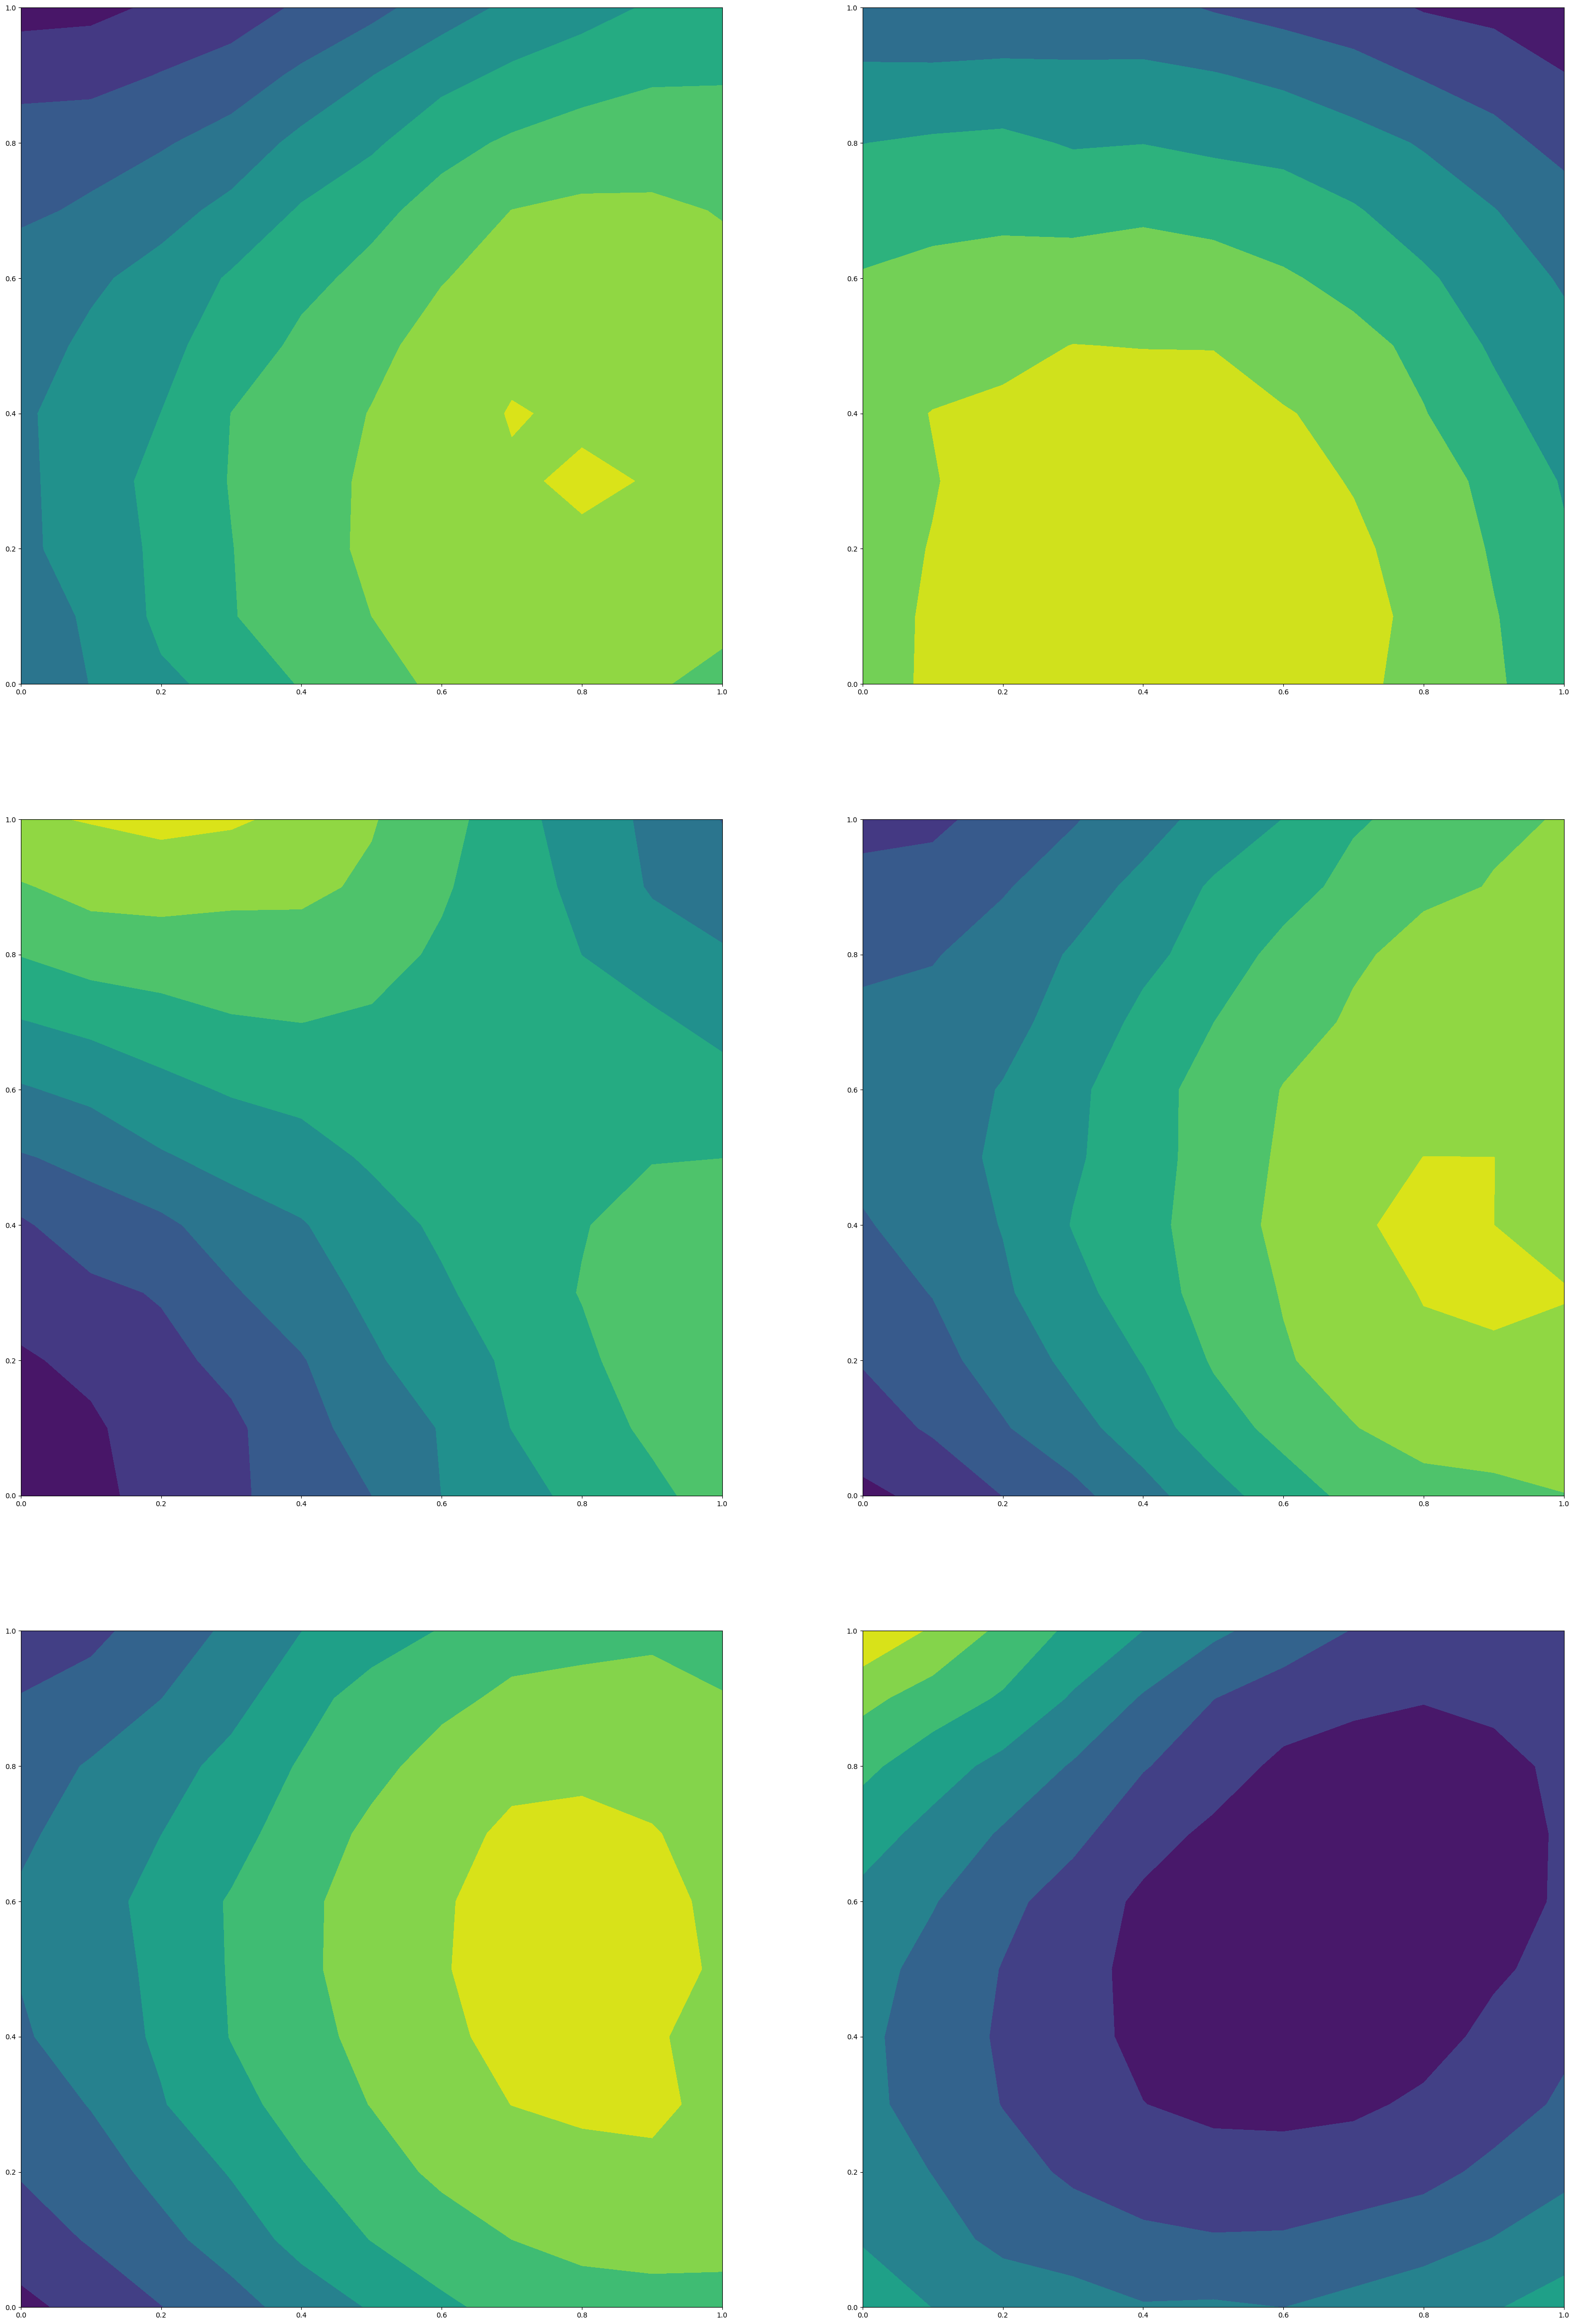

In [6]:
# Plot
[Xt,Yt] = np.meshgrid(X[:,0].unique().numpy(),X[:,1].unique().numpy())
%matplotlib inline
f, ((y1_ax, y2_ax), (y3_ax, y4_ax), (y5_ax, y6_ax)) = plt.subplots(3, 2, figsize=(40, 60))
y1_ax.contourf(Xt,Yt,y[:,0].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y2_ax.contourf(Xt,Yt,y[:,3].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y3_ax.contourf(Xt,Yt,y[:,1].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y4_ax.contourf(Xt,Yt,y[:,4].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y5_ax.contourf(Xt,Yt,y[:,2].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y6_ax.contourf(Xt,Yt,y[:,5].reshape(Xt.shape).detach().numpy(),cmap='viridis')
None

In [7]:
# If we are in the symmetric setting, expand the input dimension
symmetric = True
if symmetric:
    n, p = y.shape
    p = 2*p
    tmp = torch.full([n,p],float('nan'))
    tmp_noise = torch.full([n,p],float('nan'))
    for i in range(N_C):
        orig = y[:,(i*N_D):(i*N_D+N_D)]
        orig_noise = s[:,(i*N_D):(i*N_D+N_D)]
        new = torch.full(orig.shape,float('nan'))
        new_noise = torch.full(orig.shape,float('nan'))
        combined = torch.cat([orig,new],-1)
        combined_noise = torch.cat([orig_noise,new_noise],-1)
        tmp[:,(i*(2*N_D)):(i*(2*N_D)+2*N_D)] = combined
        tmp_noise[:,(i*(2*N_D)):(i*(2*N_D)+2*N_D)] = combined_noise
    y = tmp
    s = tmp_noise

In [8]:
# Fill in missing values with dummy variables and mask
# Pad with missing values and large noise
mVAL = -999
mVAR = 99999999999999
missing_idx = y.isnan()
N_missing = missing_idx.sum()
# Train output is given a fixed dummy values
y = y.masked_fill(missing_idx,mVAL)
# Correspondingly these are given a large noise
s = s.masked_fill(missing_idx,mVAR)

In [9]:
# Define some constants
if symmetric:
    N_tasks = 2*N_T
else:
    N_tasks = N_T
N_total = y.numel()
N_obs = int(N_total-N_missing)

In [10]:
from synpred.likelihoods.fixed_noise_multitask_gaussian_likelihood import FixedNoiseMultitaskGaussianLikelihood
from synpred.kernels.piicm import PIICM

In [11]:
# Here now set up the model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=N_tasks
        )
        self.covar_module = PIICM(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), 
            num_combinations = N_D, num_cell_lines=N_C,  
            drug_rank=2*d_rank, cell_linerank = c_rank,
            symmetric=symmetric
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, interleaved=True)

    
likelihood = FixedNoiseMultitaskGaussianLikelihood(num_tasks=N_tasks,noise=s)
model = MultitaskGPModel(X, y, likelihood)

/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/synpred-0.0.1-py3.10.egg/synpred/likelihoods/fixed_noise_multitask_gaussian_likelihood.py:79: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.


In [12]:
max_iter = 200

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters
# Loss
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)
# Keeping track of loss
m = []
eps = 1e-4
diff = 10

with gpytorch.settings.verbose_linalg(False), gpytorch.settings.max_preconditioner_size(0):
    with gpytorch.settings.max_cg_iterations(2000):
            with gpytorch.settings.cg_tolerance(0.01):
                for i in range(max_iter):
                    optimizer.zero_grad()
                    output = model(X)
                    loss = -mll(output,y)
                    loss.backward()
                    optimizer.step()
                    m.append(loss.item())
                    if i > 0:
                        diff = abs(m[i]-m[i-1])
                    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f  loss difference: %.4f' % (
                        i + 1, max_iter, loss.item(),
                        model.covar_module.data_covar_module.base_kernel.lengthscale.item(),
                        model.likelihood.global_noise.item(),
                        diff
                    ))
                    if diff < eps:
                        print('Model converged!')
                        break

    
    


/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Trigg

Iter 1/200 - Loss: 0.863   lengthscale: 0.668   noise: 0.669  loss difference: 10.0000
Iter 2/200 - Loss: 0.832   lengthscale: 0.645   noise: 0.644  loss difference: 0.0312
Iter 3/200 - Loss: 0.808   lengthscale: 0.621   noise: 0.621  loss difference: 0.0240
Iter 4/200 - Loss: 0.789   lengthscale: 0.599   noise: 0.598  loss difference: 0.0191
Iter 5/200 - Loss: 0.773   lengthscale: 0.578   noise: 0.576  loss difference: 0.0156
Iter 6/200 - Loss: 0.760   lengthscale: 0.558   noise: 0.554  loss difference: 0.0130
Iter 7/200 - Loss: 0.749   lengthscale: 0.540   noise: 0.533  loss difference: 0.0110
Iter 8/200 - Loss: 0.740   lengthscale: 0.523   noise: 0.512  loss difference: 0.0095
Iter 9/200 - Loss: 0.731   lengthscale: 0.507   noise: 0.492  loss difference: 0.0085
Iter 10/200 - Loss: 0.723   lengthscale: 0.492   noise: 0.473  loss difference: 0.0078
Iter 11/200 - Loss: 0.716   lengthscale: 0.479   noise: 0.454  loss difference: 0.0074
Iter 12/200 - Loss: 0.709   lengthscale: 0.467   no

Iter 96/200 - Loss: -0.065   lengthscale: 0.332   noise: 0.008  loss difference: 0.0067
Iter 97/200 - Loss: -0.070   lengthscale: 0.329   noise: 0.008  loss difference: 0.0051
Iter 98/200 - Loss: -0.073   lengthscale: 0.325   noise: 0.008  loss difference: 0.0023
Iter 99/200 - Loss: -0.074   lengthscale: 0.323   noise: 0.007  loss difference: 0.0015
Iter 100/200 - Loss: -0.077   lengthscale: 0.323   noise: 0.007  loss difference: 0.0033
Iter 101/200 - Loss: -0.082   lengthscale: 0.325   noise: 0.007  loss difference: 0.0046
Iter 102/200 - Loss: -0.088   lengthscale: 0.327   noise: 0.007  loss difference: 0.0058
Iter 103/200 - Loss: -0.094   lengthscale: 0.327   noise: 0.006  loss difference: 0.0062
Iter 104/200 - Loss: -0.098   lengthscale: 0.325   noise: 0.006  loss difference: 0.0041
Iter 105/200 - Loss: -0.100   lengthscale: 0.323   noise: 0.006  loss difference: 0.0019
Iter 106/200 - Loss: -0.102   lengthscale: 0.321   noise: 0.006  loss difference: 0.0018
Iter 107/200 - Loss: -0.1

In [14]:
# Evaluate model
model.eval()
likelihood.eval()


# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.max_cg_iterations(4000):
    with gpytorch.settings.skip_posterior_variances(True), gpytorch.settings.verbose_linalg(False):
        with gpytorch.settings.max_preconditioner_size(0):
            predictions = likelihood(model(X))
            mean = predictions.mean
            #lower, upper = predictions.confidence_region()

In [15]:
if symmetric:
    n, p = mean.shape
    p = int(p/2)
    tmp = torch.full([n,p],float('nan'))
    for i in range(N_C):
        tmp[:,(i*N_D):(i*N_D+N_D)] = mean[:,(i*(2*N_D)):(i*(2*N_D)+N_D)]

62
69


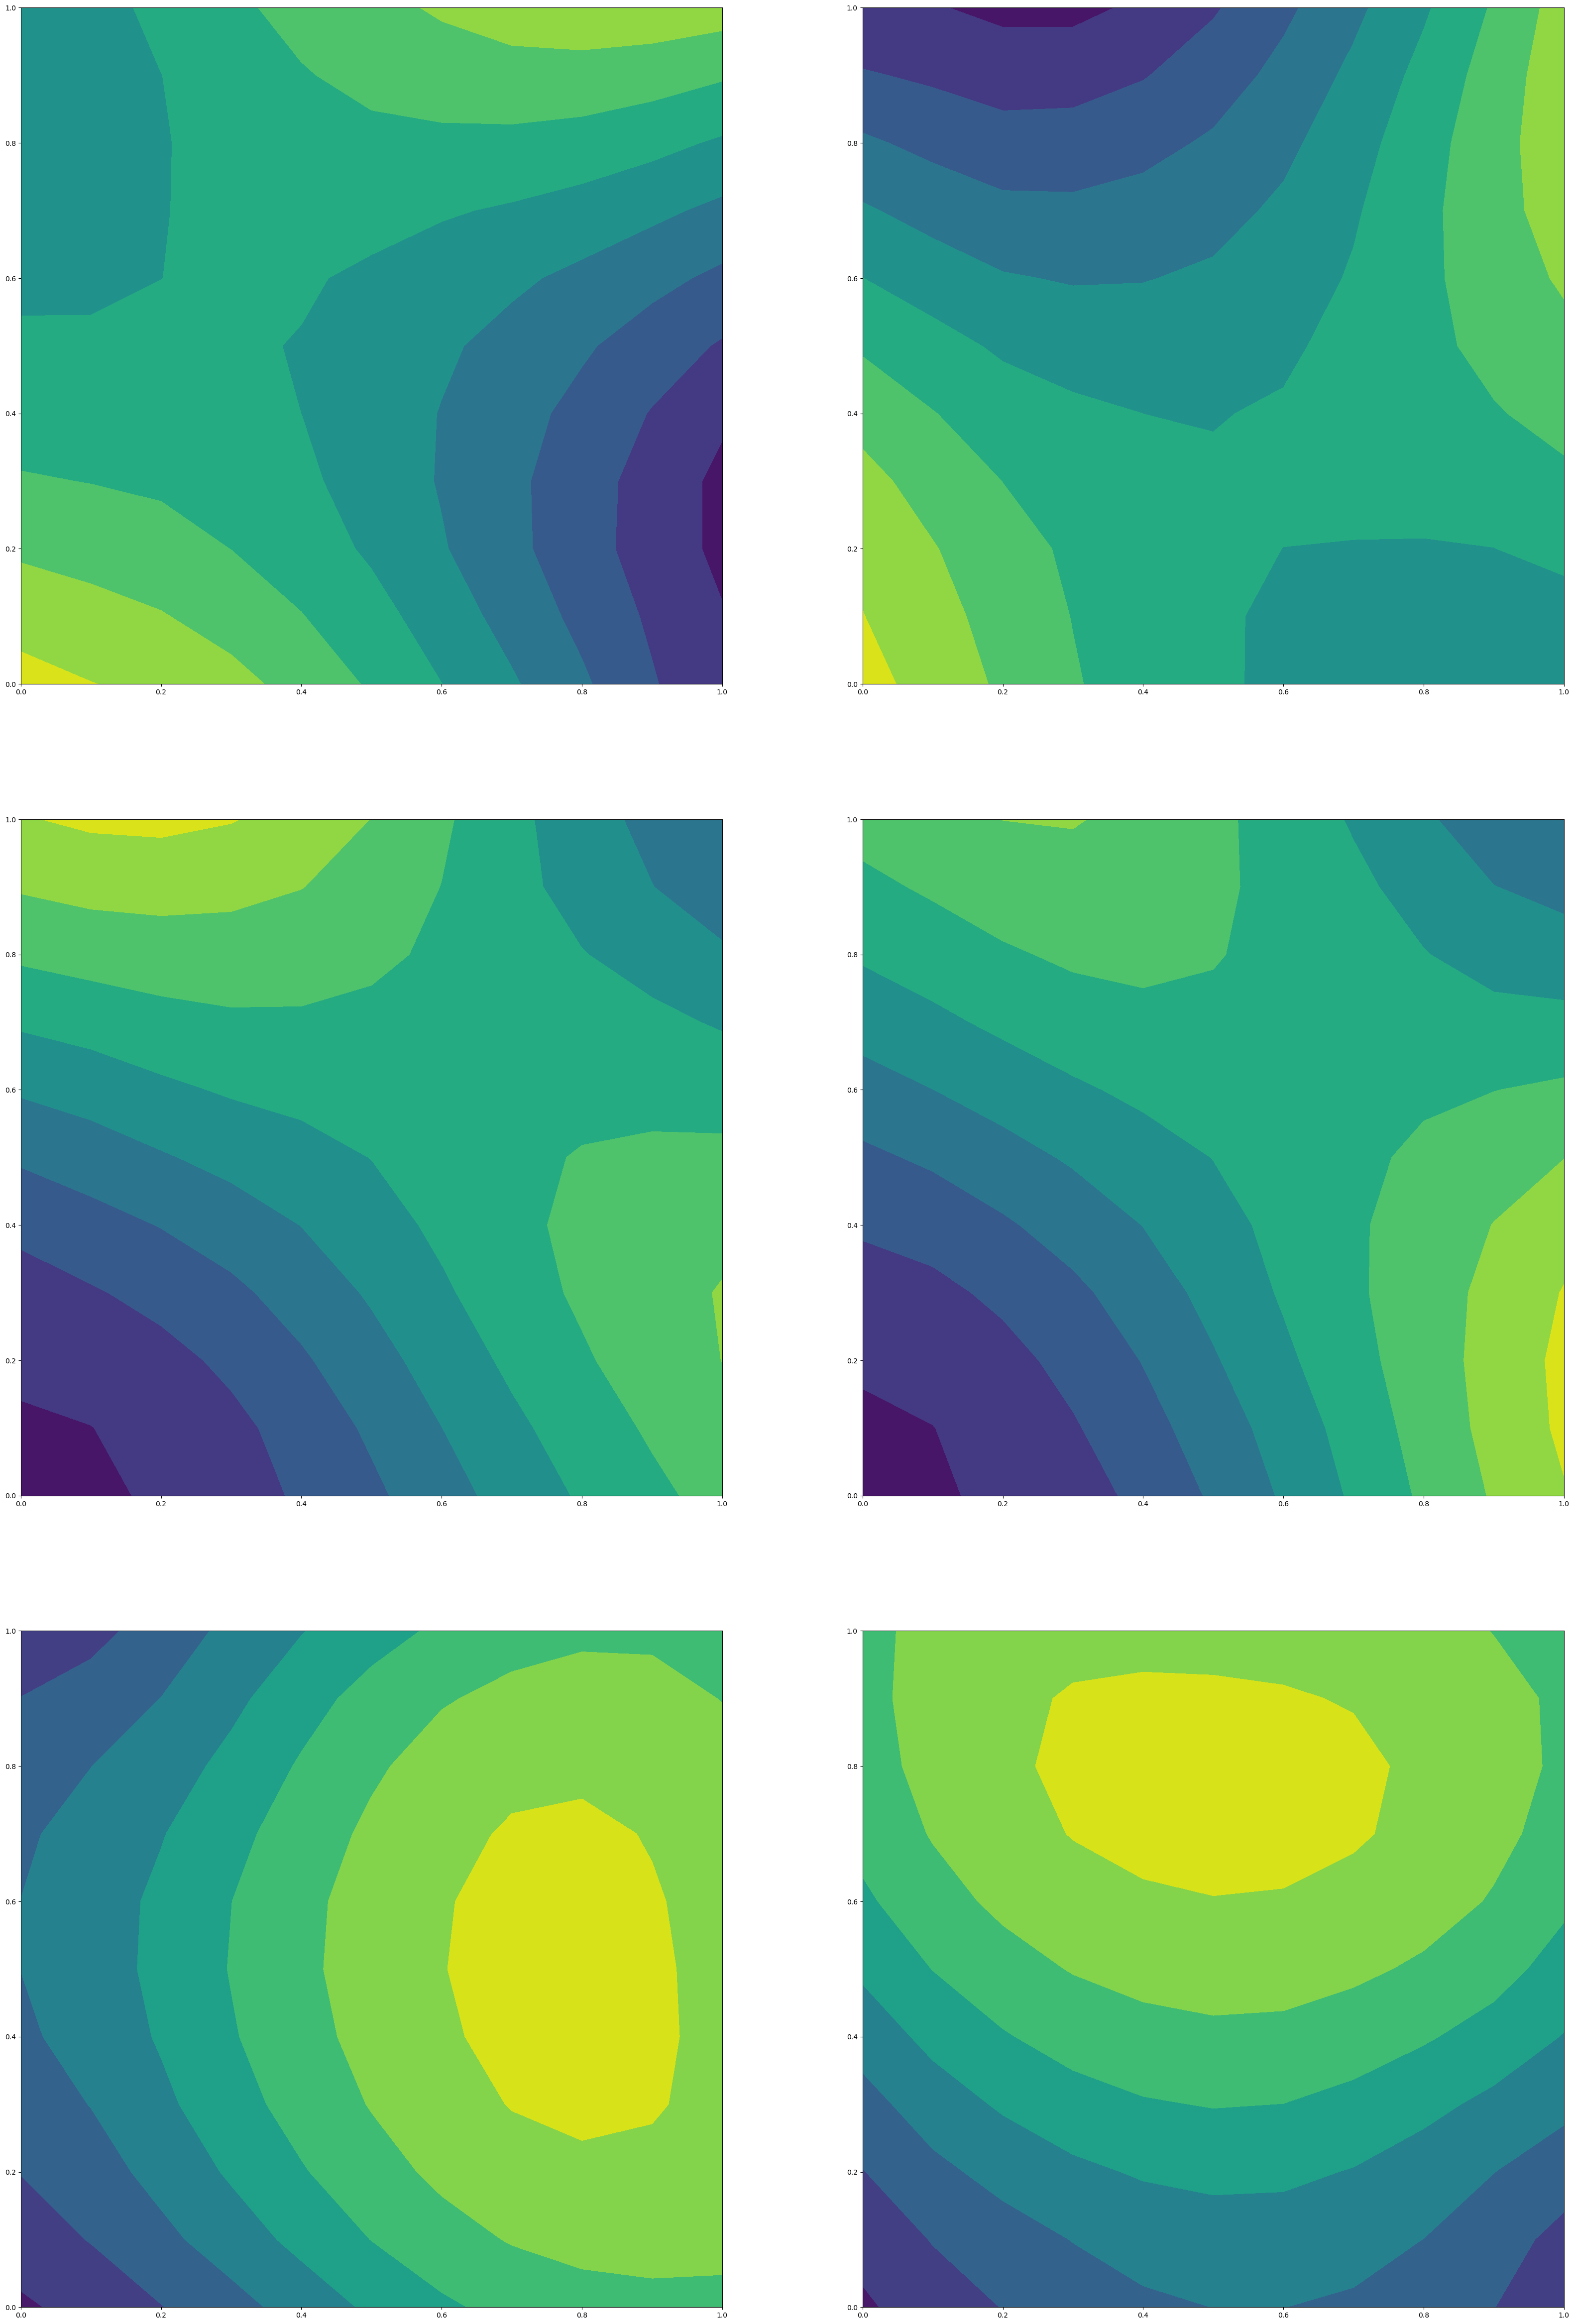

In [16]:
# Plot
[Xt,Yt] = np.meshgrid(X[:,0].unique().numpy(),X[:,1].unique().numpy())
%matplotlib inline
f, ((y1_ax, y2_ax), (y3_ax, y4_ax), (y5_ax, y6_ax)) = plt.subplots(3, 2, figsize=(40, 60))
#f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(10, 5))
cell = 4
drug = 6
task = (cell*2*N_D) + drug
print(task)
task_reflected = task + N_D
print(task_reflected)
y1_ax.contourf(Xt,Yt,mean[:,task].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y2_ax.contourf(Xt,Yt,mean[:,task_reflected].reshape(Xt.shape).detach().numpy(),cmap='viridis')
task = 1
task_reflected = task + N_D
y3_ax.contourf(Xt,Yt,mean[:,task].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y4_ax.contourf(Xt,Yt,mean[:,task_reflected].reshape(Xt.shape).detach().numpy(),cmap='viridis')
task = 2
task_reflected = task + N_D
y5_ax.contourf(Xt,Yt,mean[:,task].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y6_ax.contourf(Xt,Yt,mean[:,task_reflected].reshape(Xt.shape).detach().numpy(),cmap='viridis')
None

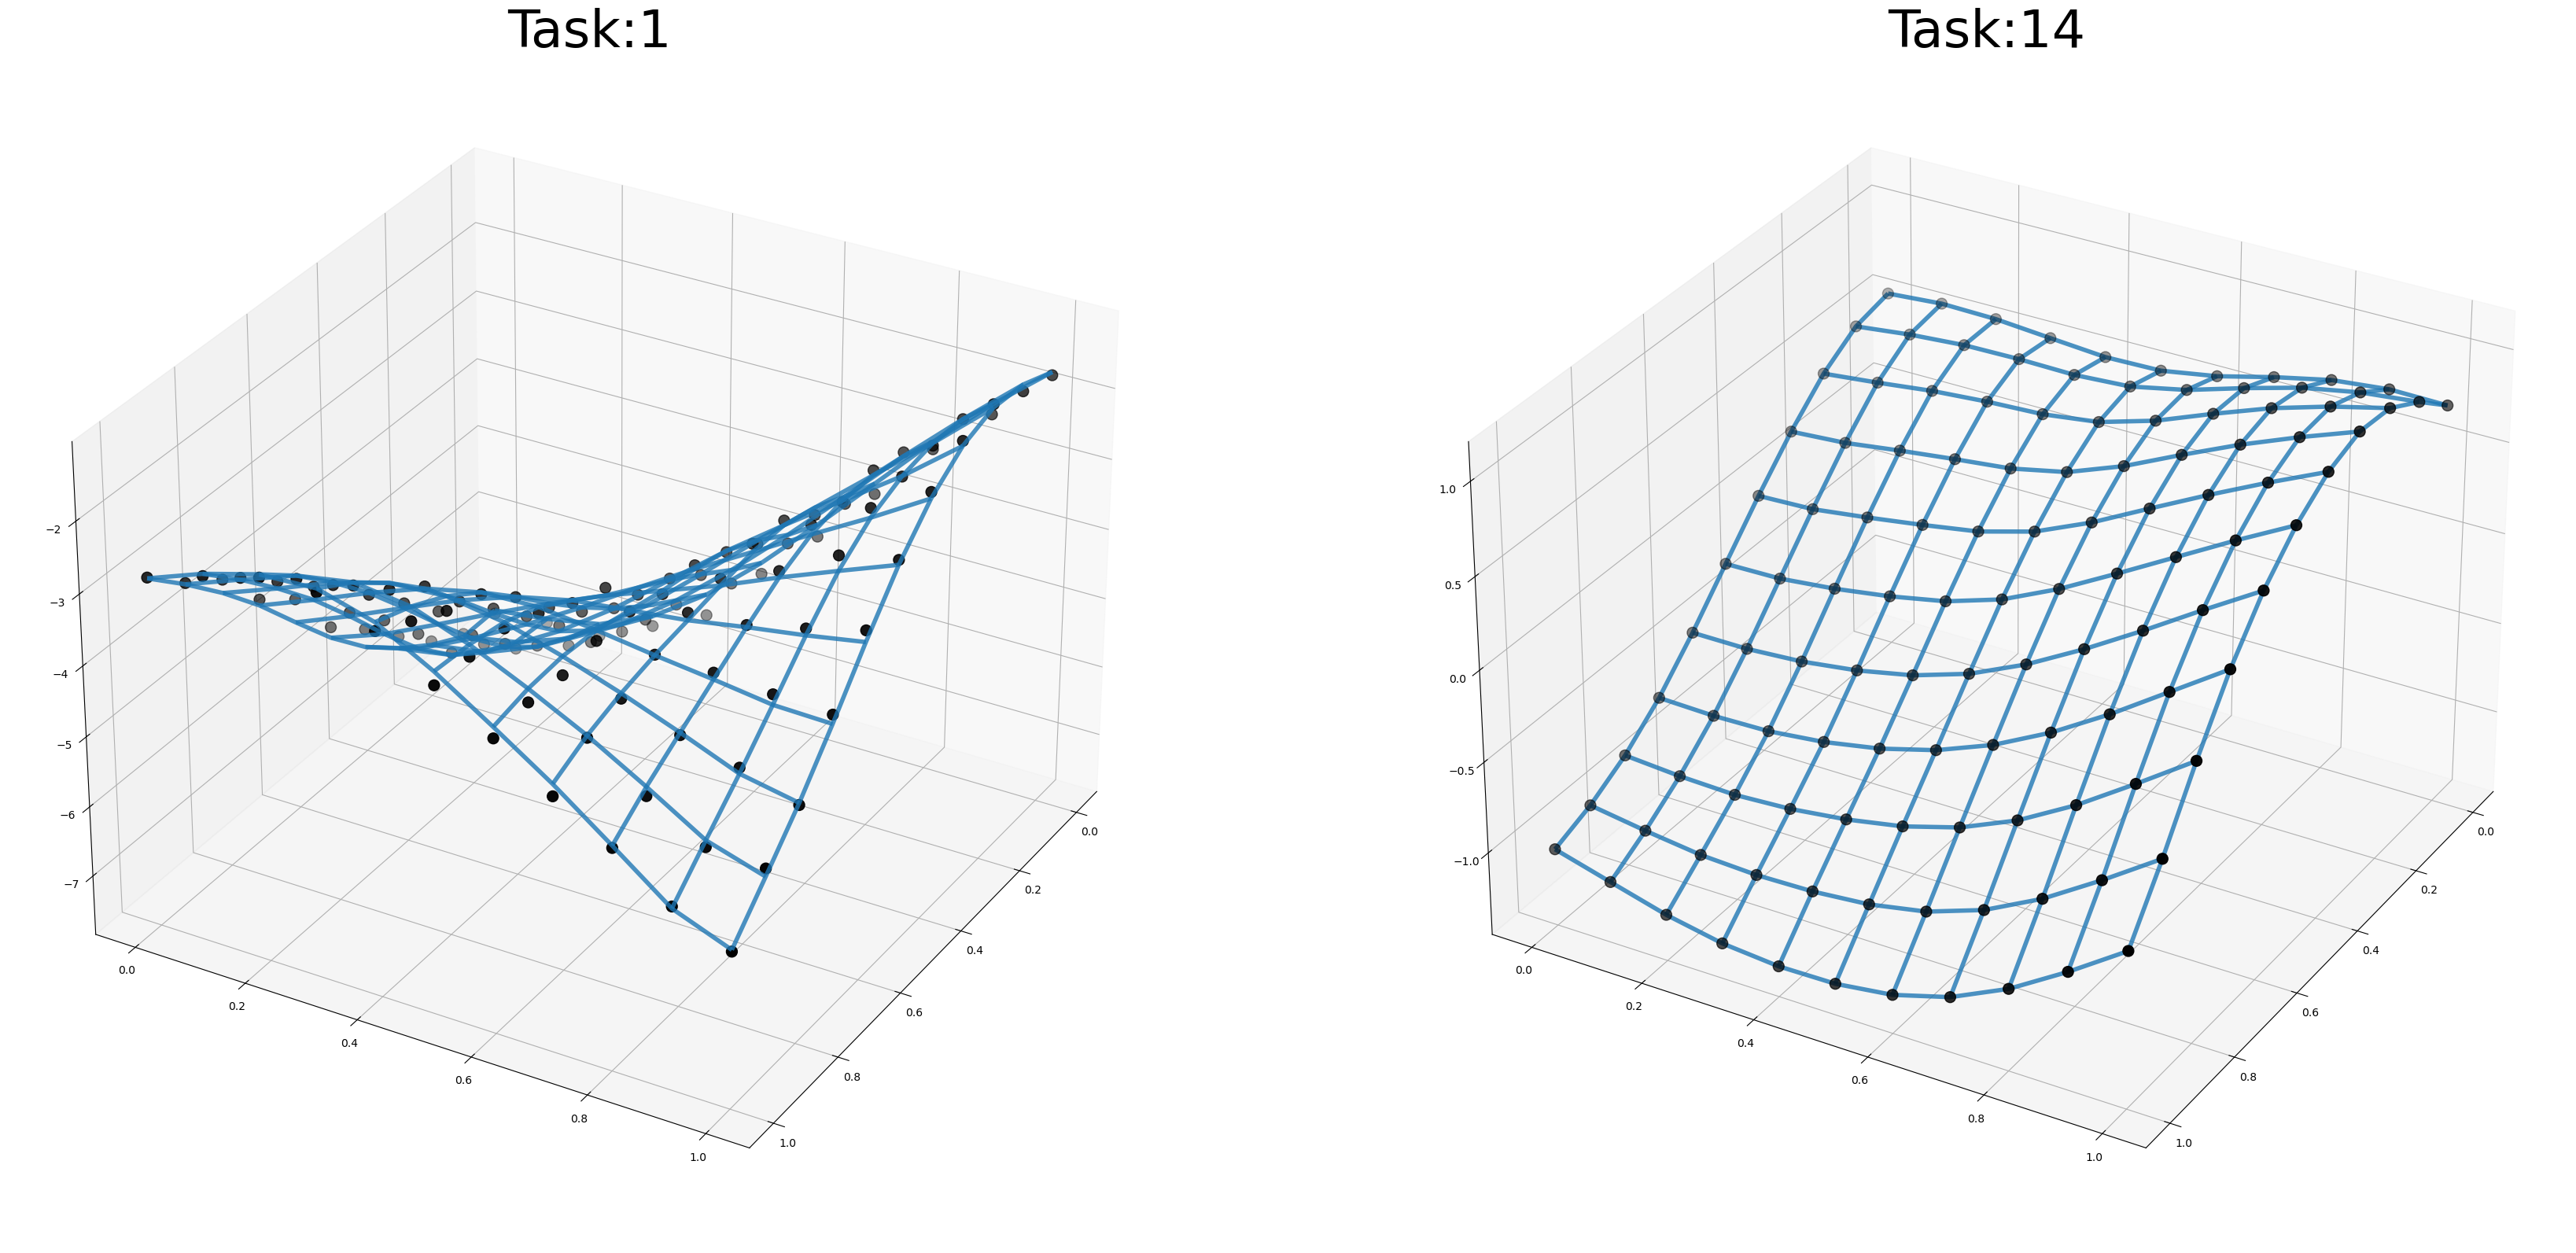

In [17]:
# Dose-response
task = 1
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
#fig = plt.figure(figsize=(20,10))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(42,20))
X_new = torch.stack((X[:,0],X[:,1]),dim=-1)


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])



ax1 = fig.add_subplot(1,2,1, projection="3d")
# Add surface
ax1.plot_wireframe(X=Xt,Y=Yt,Z=mean[:,task].reshape(Xt.shape).detach().numpy(),cmap=plt.get_cmap('viridis'), alpha=0.8, linewidth=4 )
# Add points
ax1.scatter(Xt,Yt,y[:,task],c='k',s=100)
ax1.view_init(azim=30,elev=30)
# Title
ax1.title.set_text("Task:"+str(task))
ax1.title.set_fontsize(48)


# Latent GP
task = 14
ax2 = fig.add_subplot(1,2,2, projection="3d")

# Add surface
ax2.plot_wireframe(X=Xt,Y=Yt,Z=mean[:,task].reshape(Xt.shape).detach().numpy(),cmap=plt.get_cmap('viridis'), alpha=0.8, linewidth=4 )
# Add points
ax2.scatter(Xt,Yt,mean[:,task],c='k',s=100)
ax2.view_init(azim=30,elev=30)
# Title
ax2.title.set_text("Task:"+str(task))
ax2.title.set_fontsize(48)


### Plotting the estimated cell line and drug covariances

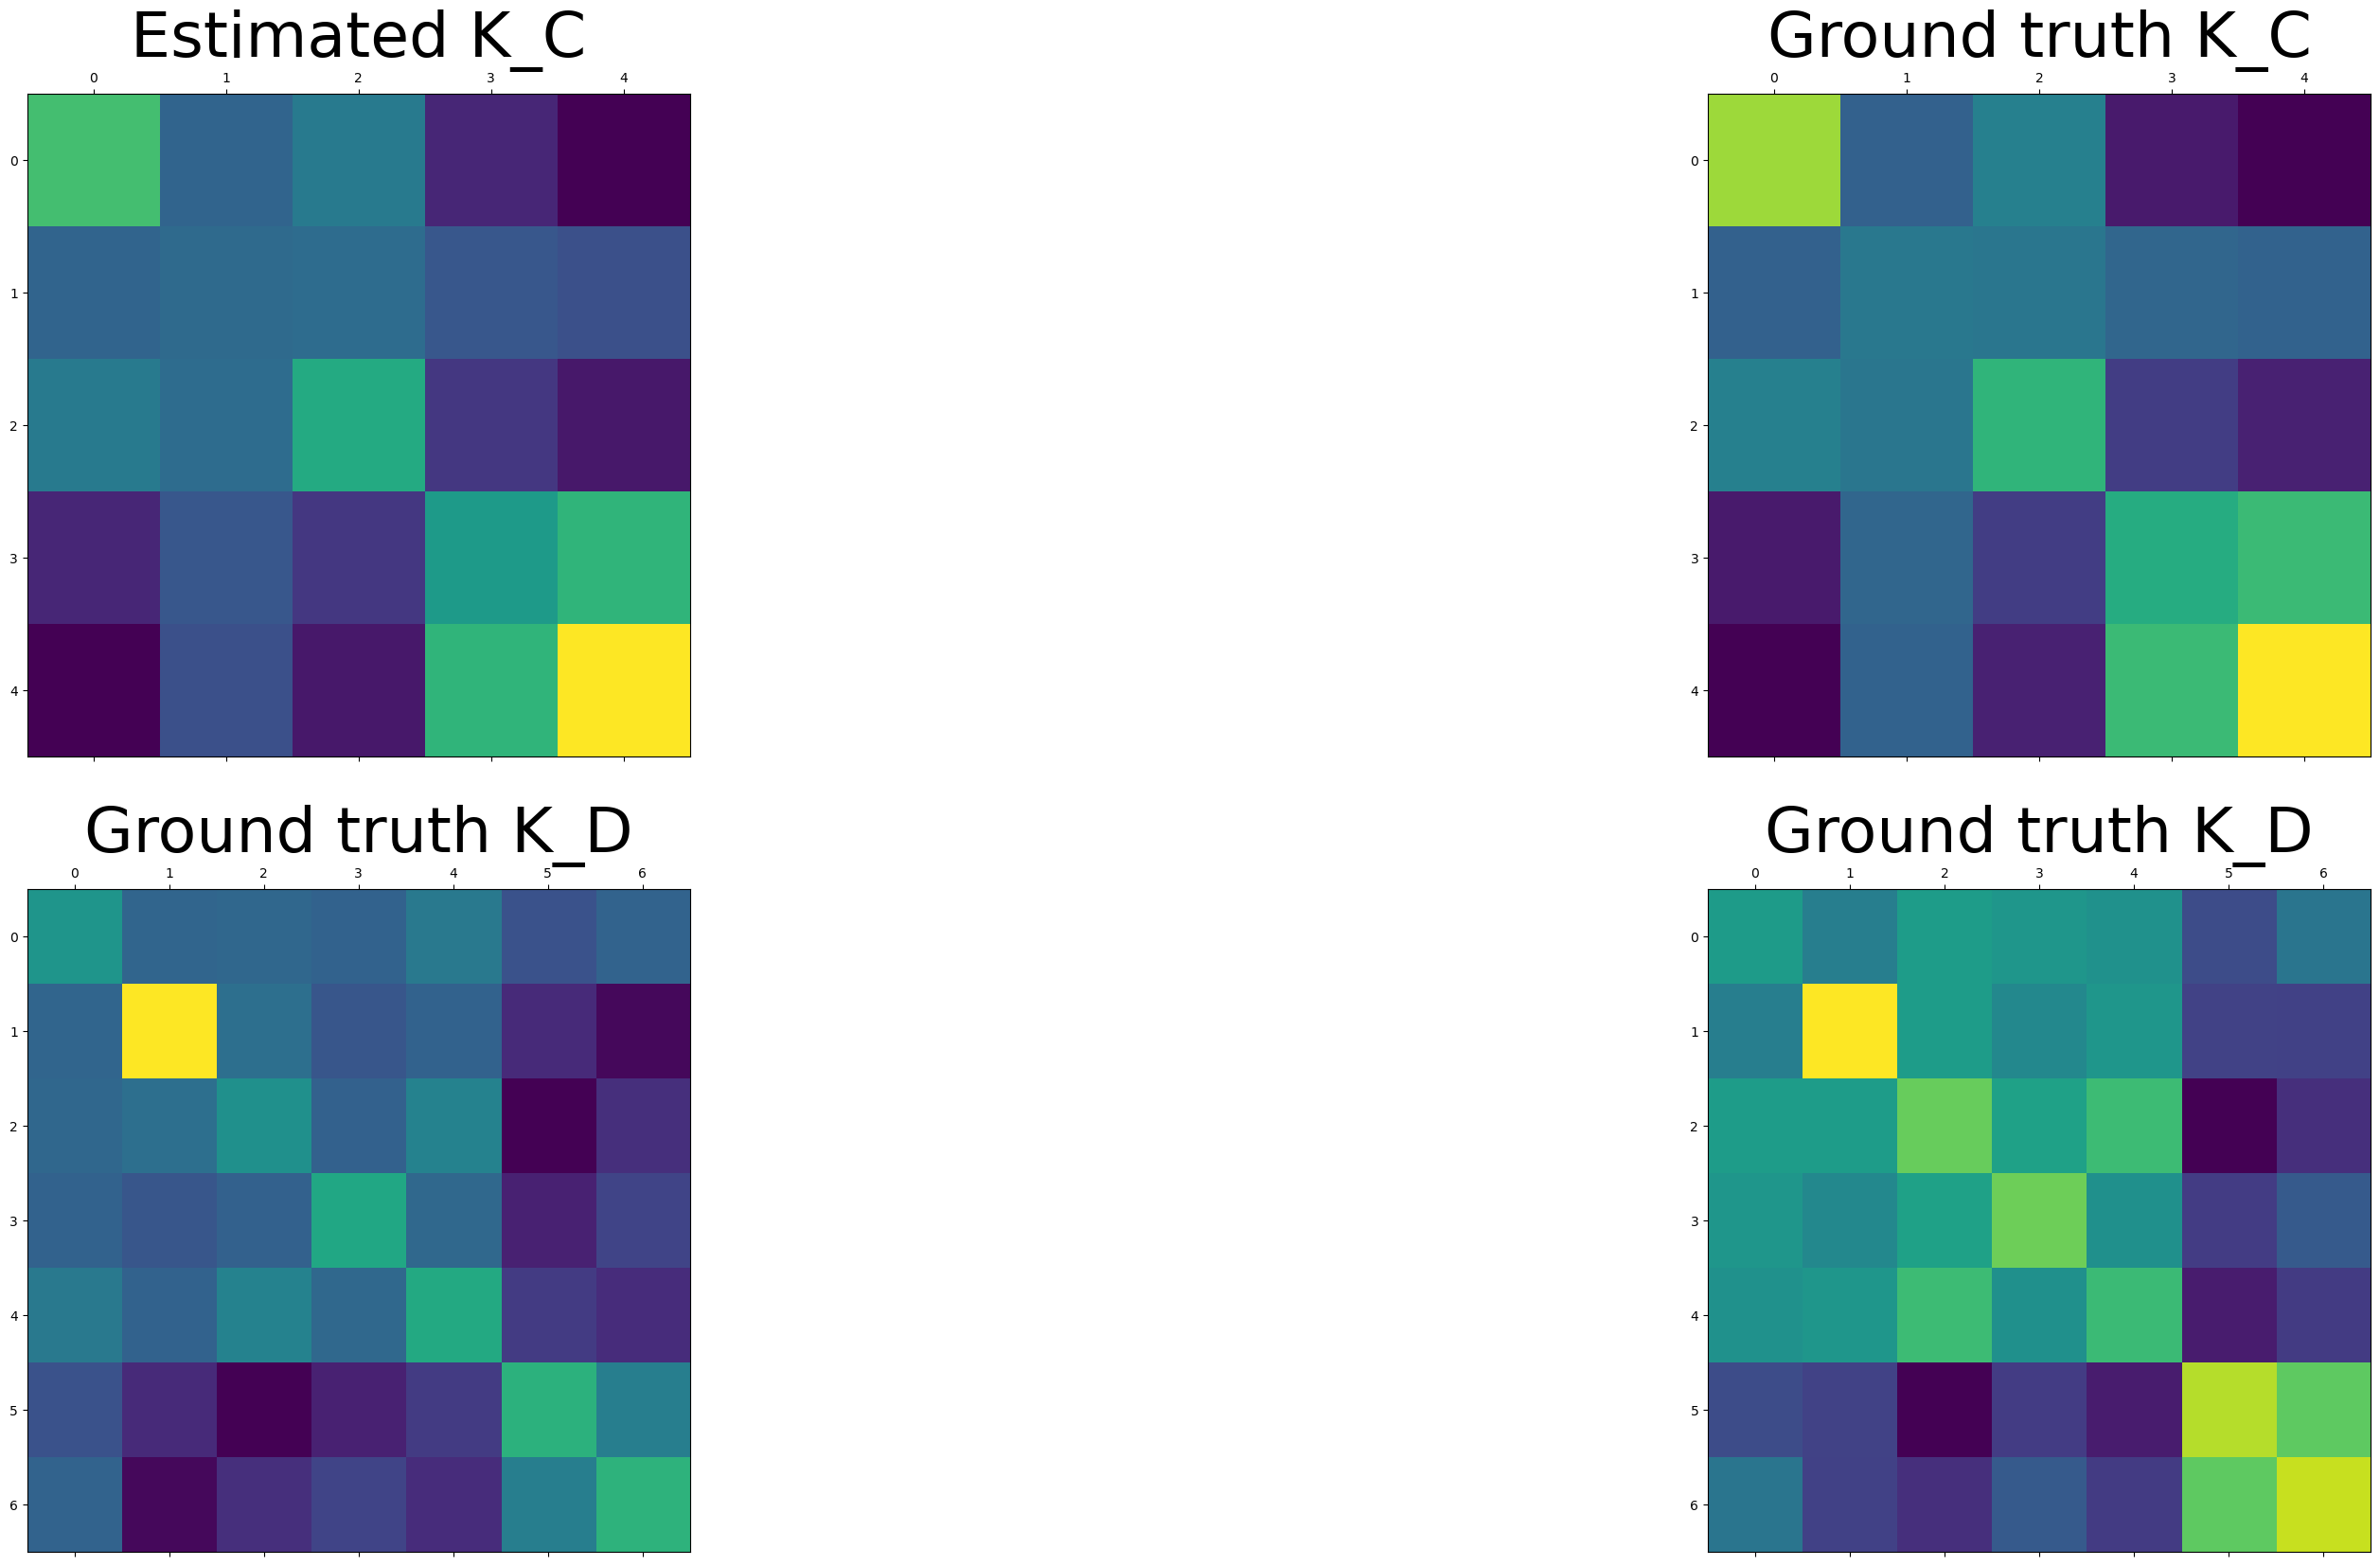

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(42,20))
cell_covar = model.covar_module.cellline_covar_module.covar_matrix.evaluate()
drug_covar = model.covar_module.drugcombo_covar_module.covar_matrix.evaluate()
ax1.matshow(cell_covar.detach().numpy())
ax1.title.set_text("Estimated K_C")
ax1.title.set_fontsize(48)
ax2.matshow(K_C.detach().numpy())
ax2.title.set_text("Ground truth K_C")
ax2.title.set_fontsize(48)
ax3.matshow(drug_covar.detach().numpy()[0:N_D,0:N_D])
ax3.title.set_text("Ground truth K_D")
ax3.title.set_fontsize(48)
ax4.matshow(K_D.detach().numpy())
ax4.title.set_text("Ground truth K_D")
ax4.title.set_fontsize(48)